# sup8A

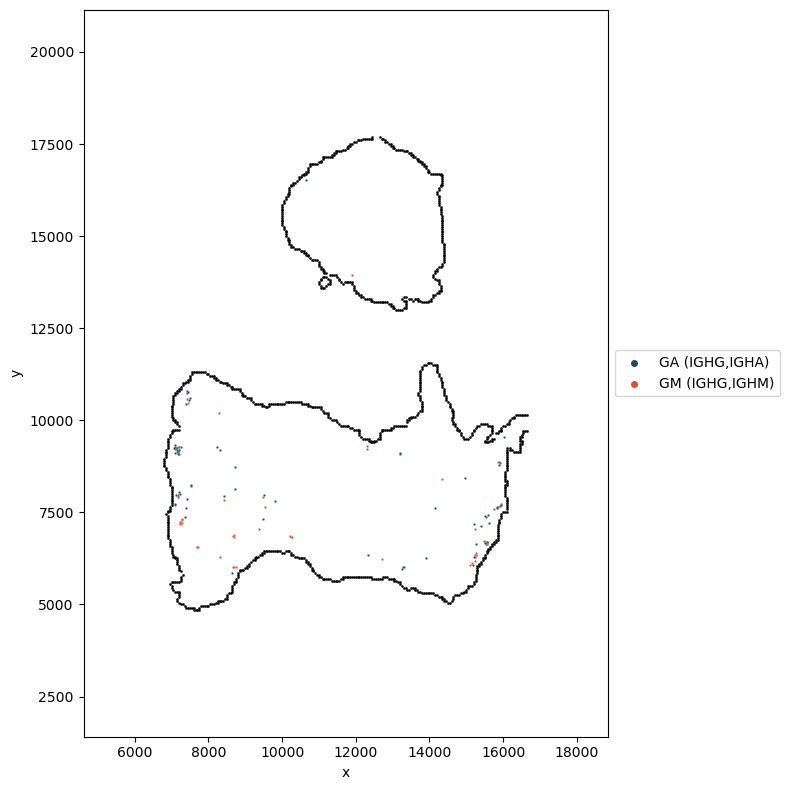

/tmp/ipykernel_2139604/3197322844.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
/tmp/ipykernel_2139604/3197322844.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cell_border_list_GM = cell_border_GM.groupby('cellID').apply(
/tmp/ipykernel_2139604/3197322844.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future 

<Figure size 1200x1200 with 0 Axes>

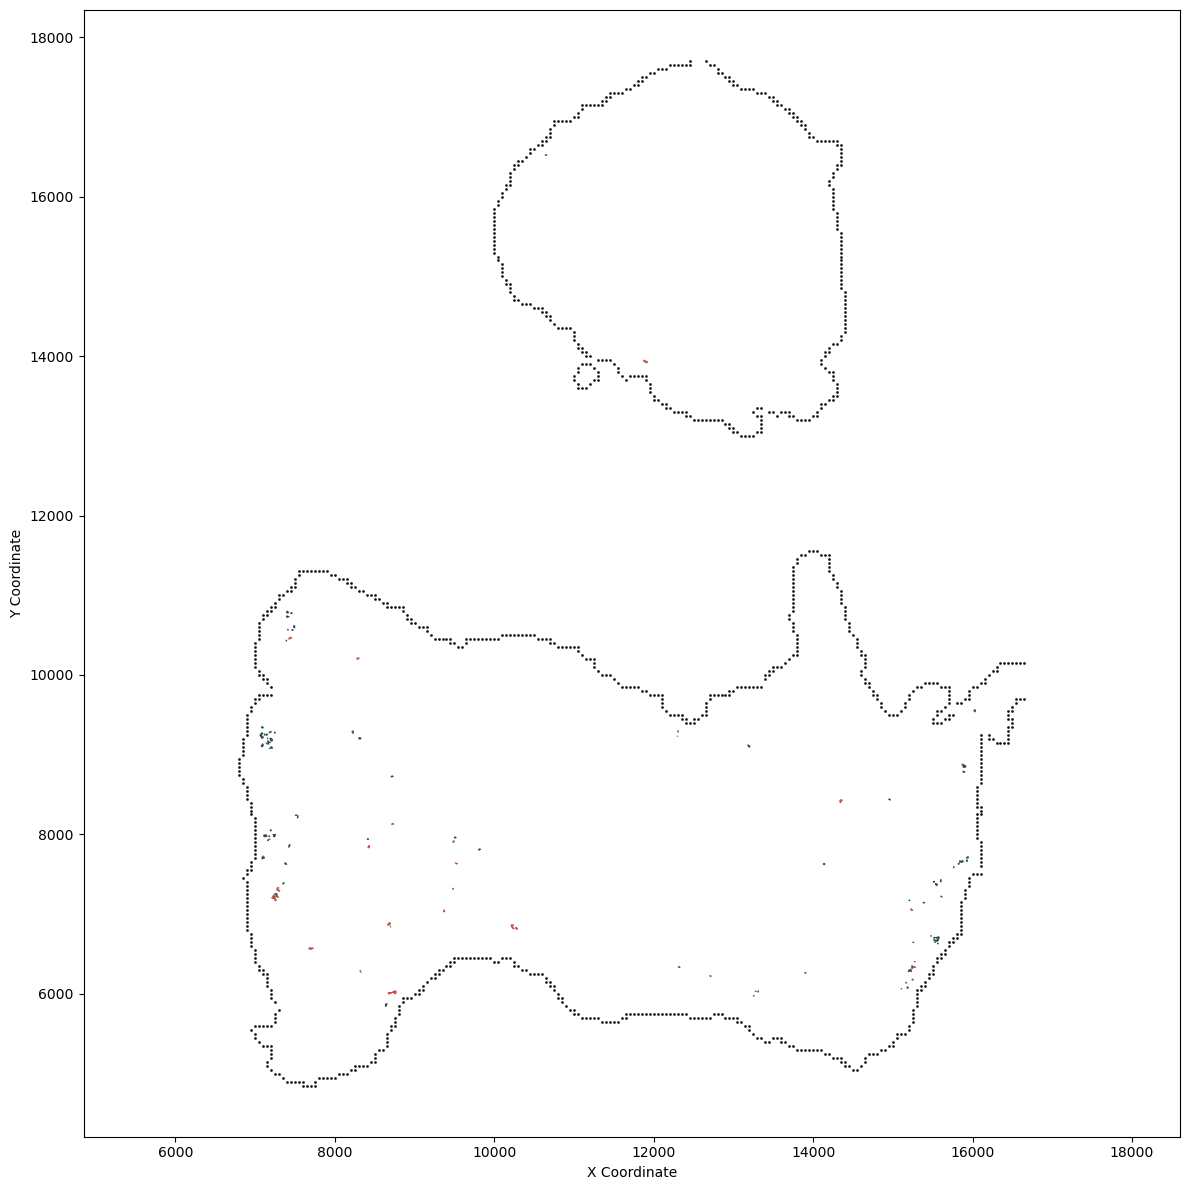

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev

# ------- 第一张图：类点分布 -------
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06050C2/test_analysis_celltype/D06050C2.h5ad')
df = adata.obs
df = df[df['batch'] == 'D06050C2']
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])

plt.figure(figsize=(8, 8))
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=3, edgecolor=None)
sns.scatterplot(
    data=df[(df['bin50 structural annotation'].isin(['LA-TLS','LA-PCA'])) & (df['classes'] == 'IGHG,IGHA')],
    x='x', y='y', color='#204B5A', s=3, label="GA (IGHG,IGHA)"
)
sns.scatterplot(
    data=df[(df['bin50 structural annotation'].isin(['LA-TLS','LA-PCA'])) & (df['classes'] == 'IGHG,IGHM')],
    x='x', y='y', color='#E64B35', s=3, label="GM (IGHG,IGHM)"
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)
plt.grid(False)
plt.axis('equal')
plt.tight_layout()
plt.show()

# ------- 第二张：细胞边界 PatchCollection -------
array_2d = adata9.obsm['cell_border'].reshape(-1, adata9.obsm['cell_border'].shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(str)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]
df_filtered = pd.merge(df_filtered, adata9.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]

df1 = adata.obs.copy()
df1 = df1[df1['batch'] == 'D06050C2'].reset_index()

data_GA = df1[
    (df1['bin50 structural annotation'].isin(['LA-TLS', 'LA-PCA'])) & (df1['classes'] == 'IGHG,IGHA')
].copy()
data_GA.rename(columns={'level_0': 'cellID'}, inplace=True)
data_GM = df1[
    (df1['bin50 structural annotation'].isin(['LA-TLS', 'LA-PCA'])) & (df1['classes'] == 'IGHG,IGHM')
].copy()
data_GM.rename(columns={'level_0': 'cellID'}, inplace=True)

data_GM['cellID'] = data_GM['cellID'].astype(int)
data_GA['cellID'] = data_GA['cellID'].astype(int)
df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)

cell_list_GM = data_GM['cellID'].tolist()
cell_list_GA = data_GA['cellID'].tolist()
cell_border_GM = df_cellborder[df_cellborder['cellID'].isin(cell_list_GM)]
cell_border_GA = df_cellborder[df_cellborder['cellID'].isin(cell_list_GA)]

cell_border_list_GM = cell_border_GM.groupby('cellID').apply(
    lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]
).tolist()
cell_border_list_GA = cell_border_GA.groupby('cellID').apply(
    lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]
).tolist()

filtered_cell_borders_list_GM = [np.array(cell) for cell in cell_border_list_GM if len(cell) > 0]
filtered_cell_borders_list_GA = [np.array(cell) for cell in cell_border_list_GA if len(cell) > 0]

GA_COLOR = '#204B5A'
GM_COLOR = '#E64B35'
BG_COLOR = 'white'
TXT_COLOR = 'black'

plt.figure(figsize=(12, 12))
fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list_GM:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0], codes[-1] = Path.MOVETO, Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             edgecolor='black',
                             facecolor=GM_COLOR,
                             lw=0.1,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list_GA:
    if len(cell_boundary) < 3:
        continue
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0], codes[-1] = Path.MOVETO, Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             edgecolor='black',
                             facecolor=GA_COLOR,
                             lw=0.1,
                             antialiased=True))

ax.add_collection(PatchCollection(patches, match_original=True))
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='black', s=3, edgecolor=None, ax=ax)

legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='GM',
           markerfacecolor=GM_COLOR, markersize=8, lw=0),
    Line2D([0], [0], marker='s', color='w', label='GA',
           markerfacecolor=GA_COLOR, markersize=8, lw=0),
]
# ax.legend(handles=legend_elements, loc='upper right')
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
plt.grid(False)
plt.axis('equal')
plt.tight_layout()
plt.show()

# sup8B

In [4]:
import scanpy as sc
import pandas as pd

# --- Read AnnData objects list ---
adata_paths = [
    '/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047C3/test_analysis_celltype/D06047C3.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047D4/test_analysis_celltype/D06047D4.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047E2/test_analysis_celltype/D06047E2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06047F6/test_analysis_celltype/D06047F6.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050A2/test_analysis_celltype/D06050A2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050C2/test_analysis_celltype/D06050C2.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050D4/test_analysis_celltype/D06050D4.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06050E4/test_analysis_celltype/D06050E4.h5ad',
    '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad'
]
batch_categories = [
    "D06047A2", "D06047C3", "D06047D4", "D06047E1", "D06047E2", "D06047F6",
    "D06050A2", "D06050C2", "D06050D4", "D06050E4", "D06053D2"
]
adata_list = [sc.read_h5ad(p) for p in adata_paths]
for ad in adata_list:
    ad.var_names_make_unique()

# --- IGHG,IGHA (GA) count summary ---
df_ga = pd.DataFrame(columns=['TLS-GA', 'PCA-GA'], index=batch_categories)
for i in range(len(batch_categories)):
    data = adata_list[i]
    batch = batch_categories[i]
    TLS = data.obs[data.obs['bin50 structural annotation'] == 'LA-TLS']
    PCA = data.obs[data.obs['bin50 structural annotation'] == 'LA-PCA']
    TLS_GA = TLS[TLS['classes'].isin(['IGHG,IGHA'])]
    PCA_GA = PCA[PCA['classes'].isin(['IGHG,IGHA'])]
    df_ga.loc[batch, 'TLS-GA'] = TLS_GA.shape[0]
    df_ga.loc[batch, 'PCA-GA'] = PCA_GA.shape[0]
df_ga.to_csv('sup8B_left_TLS_GA_PCA_GA_counts.csv')
print("CSV 文件已生成，文件名为：sup8B_left_TLS_GA_PCA_GA_counts.csv")

# --- IGHG,IGHM (GM) count summary ---
df_gm = pd.DataFrame(columns=['TLS-GM', 'PCA-GM'], index=batch_categories)
for i in range(len(batch_categories)):
    data = adata_list[i]
    batch = batch_categories[i]
    TLS = data.obs[data.obs['bin50 structural annotation'] == 'LA-TLS']
    PCA = data.obs[data.obs['bin50 structural annotation'] == 'LA-PCA']
    TLS_GM = TLS[TLS['classes'].isin(['IGHG,IGHM'])]
    PCA_GM = PCA[PCA['classes'].isin(['IGHG,IGHM'])]
    df_gm.loc[batch, 'TLS-GM'] = TLS_GM.shape[0]
    df_gm.loc[batch, 'PCA-GM'] = PCA_GM.shape[0]
df_gm.to_csv('sup8B_left_TLS_GM_PCA_GM_counts.csv')
print("CSV 文件已生成，文件名为：sup8B_left_TLS_GM_PCA_GM_counts.csv")

CSV 文件已生成，文件名为：sup8B_left_TLS_GA_PCA_GA_counts.csv
CSV 文件已生成，文件名为：sup8B_left_TLS_GM_PCA_GM_counts.csv


# sup8CD

/home/fengyu/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


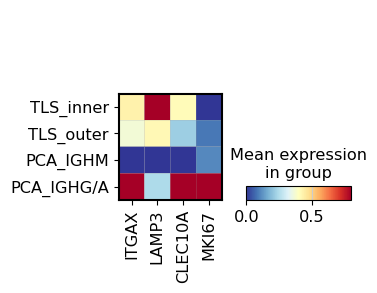

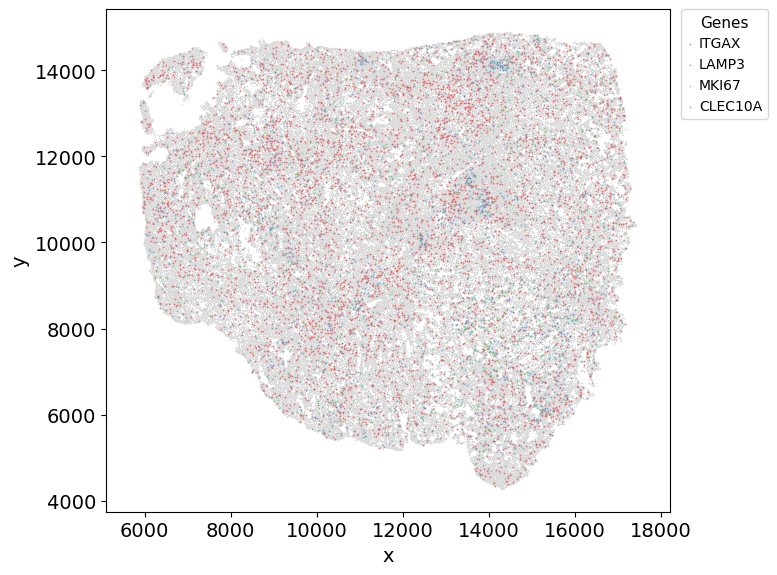

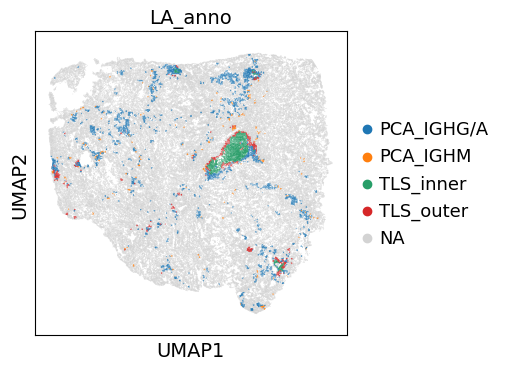

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=True)
vector(False)

# -------- Matrixplot for all batches (Supp Fig) --------
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
adata.obs.index = adata.obs.index.astype(str)
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)
adata.obs['loc'] = adata.obs['batch'].astype(str) + '_' + adata.obs['bin50_x'].map(str) + '_' + adata.obs['bin50_y'].map(str)
adata.obs = adata.obs.merge(meta[['loc','LA_anno']], on='loc', how='left')
adata.obs.index = adata.obs.index.astype(str)

order = ['TLS_inner', 'TLS_outer', 'PCA_IGHM', 'PCA_IGHG/A']
sc.pl.matrixplot(
    adata[adata.obs['LA_anno'].notna()],
    ['ITGAX', 'LAMP3', 'CLEC10A', 'MKI67'],
    groupby='LA_anno',
    standard_scale='var',
    categories_order=order,
    cmap='RdYlBu_r',
    vmax=0.8
)

# -------- D06047A2 spatial scatter for 4 genes --------
adata = adata[adata.obs['batch'] == 'D06047A2'].copy()
genes = ['ITGAX', 'LAMP3', 'MKI67', 'CLEC10A']
adata.obs.index = adata.obs.index.astype(str)
gX = adata[:, genes].X
if hasattr(gX, 'toarray'):
    gX = gX.toarray()
adata.obs[genes] = gX
df = adata.obs

plt.figure(figsize=(8, 6))
# Background: all spots
sns.scatterplot(data=df, x='x', y='y', s=1, color='lightgray', label='_nolegend_')
# Overlay: non-zero gene-expressing
sns.scatterplot(data=df[df['ITGAX'] != 0], x='x', y='y', s=2, alpha=0.5, color='#E41A1C', label='ITGAX')
sns.scatterplot(data=df[df['LAMP3'] != 0], x='x', y='y', s=2, alpha=0.5, color='#377EB8', label='LAMP3')
sns.scatterplot(data=df[df['MKI67'] != 0], x='x', y='y', s=2, alpha=0.5, color='#4DAF4A', label='MKI67')
sns.scatterplot(data=df[df['CLEC10A'] != 0], x='x', y='y', s=2, alpha=0.5, color='#9656a2', label='CLEC10A')
# Legend right outside
plt.legend(
    title='Genes',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True,
    fontsize=10,
    title_fontsize=11
)
plt.axis('equal')
plt.grid(False)
plt.tight_layout()
#plt.savefig('gene_spatial_distribution.png', dpi=1200, bbox_inches='tight')
plt.show()

# -------- UMAP plot for LA_anno --------
adata.obsm['X_umap'] = adata.obsm['spatial']
sc.pl.umap(adata, color='LA_anno', show=False)
plt.axis('equal')
#plt.savefig('LA_anno.png', dpi=2500)
plt.show()

# sup8F

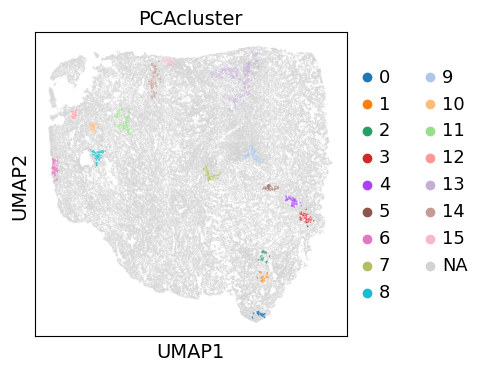

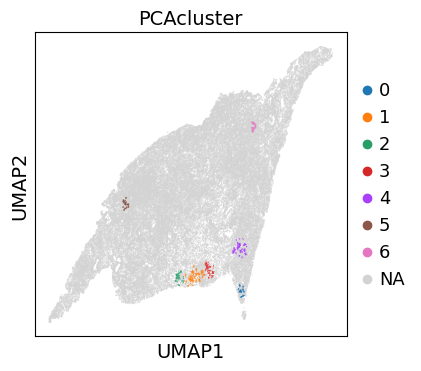

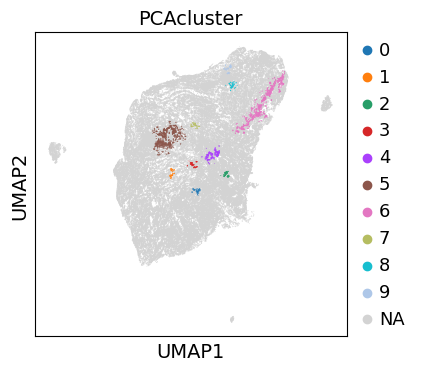

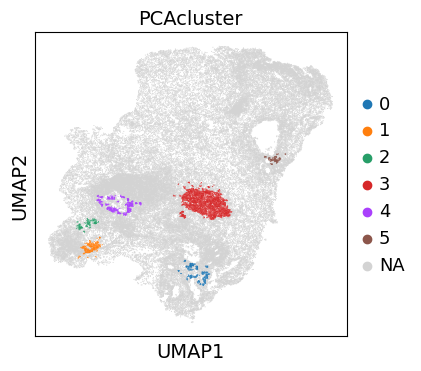

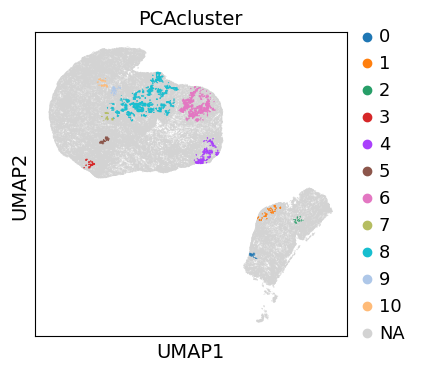

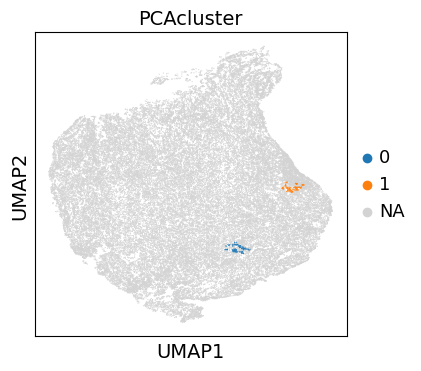

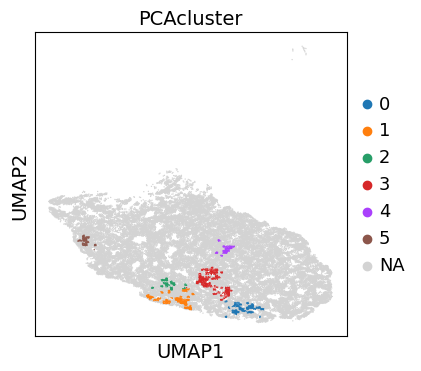

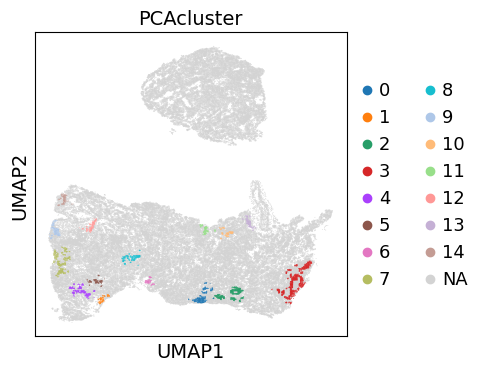

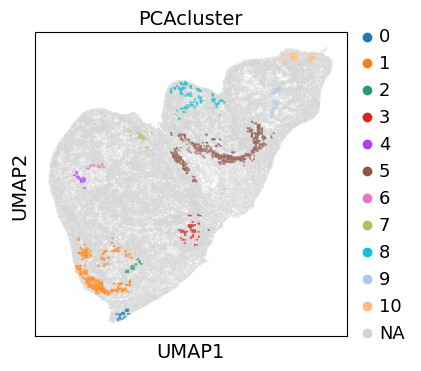

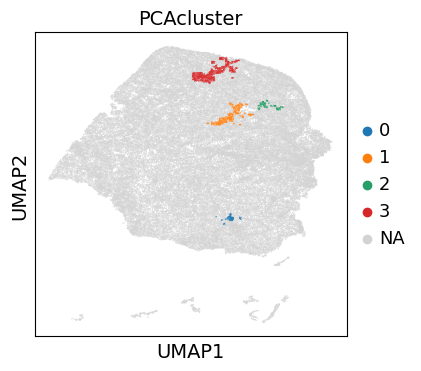

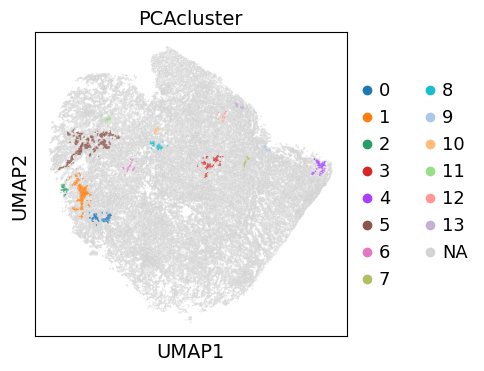

In [7]:
import scanpy as sc
import pandas as pd
adata1 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad')
adata2 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047C3/test_analysis_celltype/D06047C3.h5ad')
adata3 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047D4/test_analysis_celltype/D06047D4.h5ad')
adata4 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad')
adata5 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047E2/test_analysis_celltype/D06047E2.h5ad')
adata6 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047F6/test_analysis_celltype/D06047F6.h5ad')
adata7 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06050A2/test_analysis_celltype/D06050A2.h5ad')
adata8 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06050C2/test_analysis_celltype/D06050C2.h5ad')
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06050D4/test_analysis_celltype/D06050D4.h5ad')
adata10 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06050E4/test_analysis_celltype/D06050E4.h5ad')
adata11 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
# 确保变量名唯一
adata_list = [adata1, adata2, adata3, adata4, adata5, adata6, adata7, adata8, adata9, adata10, adata11]
for adata in adata_list:
    adata.var_names_make_unique()
    adata.obsm['X_umap'] = adata.obsm['spatial']
for i in range(11):
    data = adata_list[i]
    sc.pl.umap(data ,color = 'PCAcluster')

# sup8G

/home/fengyu/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


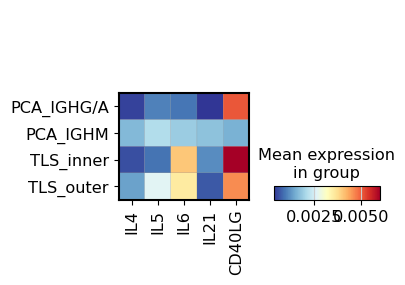

In [8]:
import scanpy as sc
import pandas as pd

adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)
adata.obs['loc'] = adata.obs['batch'].astype(str) + '_' + adata.obs['bin50_x'].map(str) + '_' + adata.obs['bin50_y'].map(str)
adata.obs = adata.obs.merge(meta[['loc','LA_anno']], on='loc', how='left')
adata.obs_names = adata.obs_names.astype(str)

tmp = adata[adata.obs['bin50 structural annotation'].isin(['LA-TLS','LA-PCA'])]

sc.pl.matrixplot(
    tmp,
    ['IL4', 'IL5', 'IL6', 'IL21', 'CD40LG'],
    groupby='LA_anno',
    cmap='RdYlBu_r',
    vmax=0.006,
)

# sup8I

/home/fengyu/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


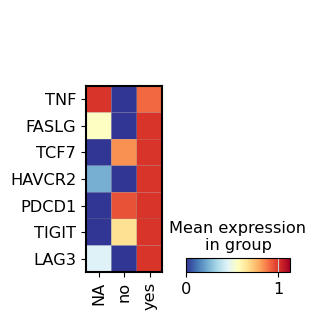

In [9]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)
adata.obs['loc'] = adata.obs['batch'].astype(str) + '_' + adata.obs['bin50_x'].map(str) + '_' + adata.obs['bin50_y'].map(str)
adata.obs = adata.obs.merge(meta[['loc','LA_anno']], on='loc', how='left')
adata.obs.index = adata.obs.index.astype(str)

# Identify shared TRBcdr3aa sequence sets for Tumor vs PCA_IGHG/A
iggTRB = adata[
    (adata.obs['LA_anno'] == 'PCA_IGHG/A') & (adata.obs['TRBcdr3aa'].notna())
].obs['TRBcdr3aa'].unique()
allTRB = adata[
    (adata.obs['TRBcdr3aa'].notna())
].obs['TRBcdr3aa'].unique()
notiggTRB = list(set(allTRB) - set(iggTRB))

adata.obs['IgGTRB'] = 'NA'
adata.obs.loc[adata.obs['TRBcdr3aa'].isin(iggTRB), 'IgGTRB'] = 'yes'
adata.obs.loc[adata.obs['TRBcdr3aa'].isin(notiggTRB), 'IgGTRB'] = 'no'

# Restrict to Tumor region
interests = adata[adata.obs['bin50 structural annotation'] == 'Tumor']

sc.pl.matrixplot(
    interests,
    ['TNF', 'FASLG', 'TCF7', 'HAVCR2', 'PDCD1', 'TIGIT', 'LAG3'],
    swap_axes=True,
    standard_scale='var',
    cmap='RdYlBu_r',
    vmax=1.12,
    groupby='IgGTRB',
    show=False
)
plt.show()